<a href="https://colab.research.google.com/github/abignu/Pix2Pix_RestauraMapas_PredClima/blob/master/Pix2Pix_TMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Aca esta el codigo de la red neuronal para el Pix2Pix Tmax

# Este modelo de Pix2Pix recibe una imagen diseñada por Agustin Bignú que representa un mapa de temperaturas máximas de USA en un día concreto. El objetivo del modelo es intentar generar
# la imagen (predicción meteorológica) del día siguiente a la imagen introducida. De esta forma será capaza de predecir como será el clima del día siguiente. 

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from datetime import datetime
from datetime import timedelta
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

TensorFlow 2.x selected.


In [0]:
import numpy as np

# Ruta de los mapas: el input y target salen de la misma tarjeta y utilizan 
# la misma carpeta

PATH = '/content/drive/My Drive/AI/Pix2PixTMAX'
INPATH = PATH + '/mapas'
OUTPATH = PATH + '/outputs'
CKPATH = PATH + '/checkpoints'

imgurls = !ls -1 "{INPATH}"

n = 4000 # vamos a entrenar a partir de los 50 hasta el 56
train_n = round(n * 0.8) # un 80% para el entrenamiento

# listado randomizado
randurls = np.copy(imgurls)

#np.random.seed(23)
#np.random.shuffle(randurls)

# particion test/train
tr_urls = randurls[:train_n] #train
ts_urls = randurls[train_n:n] #test

print(len(imgurls),len(tr_urls),len(ts_urls))
#print(tr_urls)

14457 3200 800


In [0]:
# vamos a usar unas funciones que nos ayudaran a darle mas variedad a las imgs
IMG_WIDTH = 256
IMG_HEIGHT = 256

# reescala img
def resize(inimg, tgimg, height, width):
  
  inimg = tf.image.resize(inimg, [height, width])
  tgimg = tf.image.resize(tgimg, [height, width])
  
  return inimg, tgimg

# normaliza la imagen en el ragno [-1,1]
def normalize(inimg, tgimg):
  
  inimg = (inimg / 127.5) - 1
  tgimg = (tgimg / 127.5) - 1
  
  return inimg, tgimg

# en este caso no necesitamos random_jitter o data augmentation
def random_jitter(inimg, tgimg):
  
  inimg, tgimg = resize(inimg, tgimg, 286, 286)
  
  stacked_image = tf.stack([inimg, tgimg], axis=0) # las superponemos y las recortamos
  cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
  
  inimg, tgimg = cropped_image[0], cropped_image[1]
  
  if tf.random.uniform(()) > 0.5:
    
    inimg = tf.image.flip_left_right(inimg)
    tgimg = tf.image.flip_left_right(tgimg)
  
  return inimg, tgimg

def fechaSiguiente(filename):
  
  #filename = tf.strings.as_string(filename)
  
  fecha = filename.split('-')
  
  date = fecha[0]
  num = fecha[1]
  resto = num.split('.')
  num = resto[0]
  formato = resto[1]
  date = datetime.strptime(date, '%Y%m%d')
  
  date = date + timedelta(days=1)
  num = int(num) + 1 
  
  num = format(num,'06d')
  date = date.strftime('%Y%m%d')
  
  return date + '-' + num + '.' + formato

# funcion que carga las imagenes: como las pide de la misma carpeta 
# las tgimg empezaran en la dos y seguiran una a una. Las input comienzan en la primera
# y luego siguen con la que antes fue la tgimg
def load_image(filename, augment=False):
  
  filename2 = fechaSiguiente(filename)
  
  inimg = tf.cast(tf.image.decode_png(tf.io.read_file(INPATH + '/' + filename)), tf.float32)[..., :3]
  
  tgimg = tf.cast(tf.image.decode_png(tf.io.read_file(INPATH + '/' + filename2)), tf.float32)[..., :3]
  
  inimg, tgimg = resize(inimg, tgimg, IMG_HEIGHT, IMG_WIDTH)
  
  if augment:
    inimg, tgimg = random_jitter(inimg, tgimg)
  
  inimg, tgimg = normalize(inimg, tgimg)
  
  return inimg, tgimg

def load_train_img(filename):
  return load_image(filename)

def load_test_img(filename):
  return load_image(filename)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


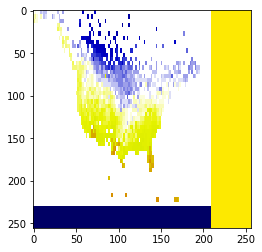

In [0]:

#read_first = True
img1, img2= load_train_img('20190301-014304.png')

plt.imshow(img1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


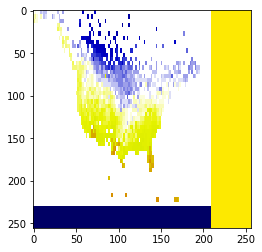

In [0]:
plt.imshow(img1)
#plt.imshow(img2)
plt.show()

In [0]:
# genero un dataset a partir de un listado de elementos que me indiques
#train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)

train_dataset = map(load_train_img, tr_urls) #mapeo entre filenames y la funcio nindicada

test_dataset = map(load_test_img, ts_urls)

inimg, tgimg = next(train_dataset)

In [0]:
#Arquitectura del modelo
from tensorflow.keras.layers import *
from tensorflow.keras import *

#funcion que genera bloques de la red neuronal (encoder)
def downsample(filters, apply_batchnorm=True):
  
  result = Sequential()
  
  initializer = tf.random_normal_initializer(0, 0.02)
  # capa convolucional
  result.add(Conv2D(filters,
                    kernel_size=4,
                    strides=2,
                    padding='same',
                    kernel_initializer=initializer,
                    use_bias=not apply_batchnorm))
  
  if apply_batchnorm:
    # capa de Batch Normalization
    result.add(BatchNormalization())
  
  # capa de activacion (leakyRELU)
  result.add(LeakyReLU())
  
  return result



In [0]:
#funcion que genera bloques de la red neuronal (decoder)
def upsample(filters, apply_dropout=False):
  
  result = Sequential()
  
  initializer = tf.random_normal_initializer(0, 0.02)
  # capa convolucional
  result.add(Conv2DTranspose(filters,
                            kernel_size=4,
                            strides=2,
                            padding='same',
                            kernel_initializer=initializer,
                            use_bias=False))
  

  # capa de Batch Normalization
  result.add(BatchNormalization())
  
  if apply_dropout:
    # capa de Dropout
    result.add(Dropout(0.5))
    
  # capa de activacion (leakyRELU)
  result.add(ReLU())
  
  return result

upsample(64)

In [0]:
def Generator():
  
  inputs = tf.keras.layers.Input(shape=[None,None,3])
  
  down_stack = [
      downsample(64, apply_batchnorm=False), #(bs, 128, 128, 64); bs = 1
      downsample(128),                       #(bs, 64, 64, 128)
      downsample(256),                       #(bs, 32, 32, 256)
      downsample(512),                       #(bs, 16, 16, 512)
      downsample(512),                       #(bs, 8, 8, 512)
      downsample(512),                       #(bs, 4, 4, 512)
      downsample(512),                       #(bs, 2, 2, 512)
      downsample(512),                       #(bs, 1, 1, 512)
  ]
  
  up_stack = [
      upsample(512, apply_dropout=True),     #(bs, 2, 2, 1024)
      upsample(512, apply_dropout=True),     #(bs, 4, 4, 1024)
      upsample(512, apply_dropout=True),     #(bs, 8, 8, 1024)
      upsample(512),                         #(bs, 16, 16, 1024)
      upsample(256),                         #(bs, 32, 32, 512)
      upsample(128),                         #(bs, 64, 64, 256)
      upsample(64),                          #(bs, 128, 128, 128)
  ]
  
  initializer = tf.random_normal_initializer(0, 0.02)
  
  # ultima capa
  last = Conv2DTranspose(filters = 3,
                         kernel_size=4,
                         strides=2,
                         padding='same',
                         kernel_initializer=initializer,
                         activation='tanh')
  
  # los conectamos, primero el decoder y luego el encoder
  x = inputs
  
  # a su vez inyectamos las skip-connections
  s = []
  concat = Concatenate()
  
  for down in down_stack:   
    x = down(x)
    s.append(x) #listado para las skip-connections
    
  s = reversed(s[:-1])  # los damos vuelta
  
  for up, sk in zip(up_stack, s):
    x = up(x)
    x = concat([x, sk]) #concatenamos las capas del encoder con las skip-conncections
    
  last = last(x)
  
  return Model(inputs=inputs, outputs=last)

In [0]:
generador = Generator()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


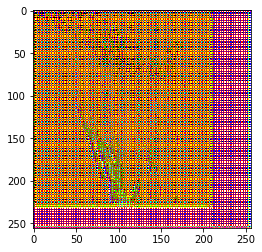

In [0]:
img = tf.expand_dims((inimg+1)*255, 0)
gen_output = generador(img, training=False)
plt.imshow(gen_output[0,...])

In [0]:
# aca esta el discriminador (PatchGAN)
def Discriminator():
  
  ini = Input(shape=[None,None,3], name='input_img')
  gen = Input(shape=[None,None,3], name='gen_img')
  
  con = concatenate([ini, gen])
  
  initializer = tf.random_normal_initializer(0, 0.02)
  
  down1 = downsample(64, apply_batchnorm=False)(con)
  down2 = downsample(128)(down1)
  down3 = downsample(256)(down2)
  down4 = downsample(512)(down3)
  
  last = tf.keras.layers.Conv2D(filters=1,
                                kernel_size=4,
                                strides=1,
                                kernel_initializer=initializer,
                                padding='same')(down4)
  
  return tf.keras.Model(inputs=[ini, gen], outputs=last)

discriminador = Discriminator()

TensorShape([1, 16, 16, 1])

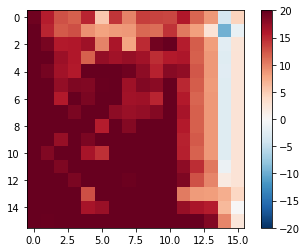

In [0]:
disc_out = discriminador([tf.expand_dims((inimg+1)*255, 0), gen_output], training=False)

plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')

plt.colorbar()

disc_out.shape

In [0]:
# ahora programamos la funcion de coste adversaria
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
# aca definimos funcion loss para el discriminador, buscamos minimizar
def discriminator_loss(disc_real_output, disc_generated_output):
  
  # diferencia entre los true por ser real y el detectado por el discriminador
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
  
  # diferencia entre los false por ser generado y el detectado por el discriminador
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
  
  total_disc_loss = real_loss + generated_loss
  
  return total_disc_loss


In [0]:
LAMBDA = 100
# aca definimos funcion loss para el generador, buscamos maximizar
def generator_loss(disc_generated_output, gen_output, target):
  
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  
  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  
  total_gen_loss = gan_loss + (LAMBDA * l1_loss)
  
  return total_gen_loss

In [0]:
import os 

# optimizadores
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# checkpoints
checkpoint_prefix= os.path.join(CKPATH, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generador,
                                 discriminator=discriminador)

# linea de codigo para restaurar el entrenamiento si se nos corta Colab
# checkpoint.restore(tf.train.latest_checkpoint(CKPATH)).assert_consumed()

In [0]:
# funcion que despliega las imagenes durante le entrenamiento
def generate_images(model, test_input, tar, filename, save_filename=False, display_imgs=True):
  
  prediction = model(test_input, training=True)
  
  if save_filename:
    tf.keras.preprocessing.image.save_img(PATH + '/outputs/predicted_{}'.format(filename) + '.jpg', prediction[0,...])
    tf.keras.preprocessing.image.save_img(PATH + '/outputs/target_{}'.format(filename) + '.jpg', tar[0,...])
    tf.keras.preprocessing.image.save_img(PATH + '/outputs/input_{}'.format(filename) + '.jpg', test_input[0,...])
    
  plt.figure(figsize=(10,10))
  
  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input img', 'Ground Truth', 'Predicted Image']
  
  if display_imgs:
    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      plt.imshow(display_list[i] * 0.5 + 0.5)
      
      plt.axis('off')
  
  plt.show()

In [0]:
# funcion train_step utilizada en el bloque anterior
@tf.function()
def train_step(input_image, target):
  
  # GradientTape() me permite hacer la backprop (similar a Torch), diferencia al Grafo Computacional
  with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:
    
    # el generador genera la imagen
    output_image = generador(tf.expand_dims(input_image, 0), training=True)

    # tarea 1 del discriminador: observa lo que genero el generador
    output_gen_discr = discriminador([output_image, tf.expand_dims(input_image, 0)], training=True)

    # tarea 2: evalua el target a ver si es real o no
    output_trg_discr = discriminador([tf.expand_dims(target,0), tf.expand_dims(input_image, 0)], training=True)

    # llamamos a las losses
    discr_loss = discriminator_loss(output_trg_discr, output_gen_discr)                       

    gen_loss = generator_loss(output_gen_discr, output_image, tf.expand_dims(target,0))

    # backprop
    generator_grads = gen_tape.gradient(gen_loss, generador.trainable_variables)
    discriminator_grads = discr_tape.gradient(discr_loss, discriminador.trainable_variables)
    
    # optimizo
    generator_optimizer.apply_gradients(zip(generator_grads, generador.trainable_variables))
    
    discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminador.trainable_variables))
    
    

In [0]:
# bloque que define rutina de entrenamiento
from IPython.display import clear_output

def train(dataset, epochs):
  for epoch in range(epochs):  
    imgi = 0
    print(epoch)
    for input_image, target in dataset:
      print('epoch ' + str(epoch) + ' - train: ' + str(imgi) + '/' + str(len(tr_urls)))
      imgi += 1
      train_step(input_image, target)
    
      clear_output(wait=True)
    
    #if epoch % 2 == 0:
      #inp, tar = next(test_dataset)
      #generate_images(generador, tf.expand_dims(inp,0), tf.expand_dims(tar,0),'_' + str(epoch), save_filename=True,display_imgs=True)
        
    # guardamos ckpts
    if (epoch + 1) % 25 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
  print('guardados')
  generador.save_weights('../weights.h5')
  generador.save('../model.h5')

In [0]:
# entrenamos
train(train_dataset, 10)

0
1
2
3
4
5
6
7
8
9
guardados


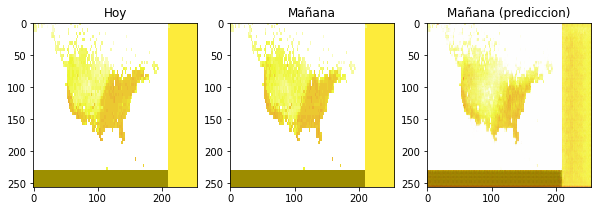

In [0]:
img, tar = load_image('20170926-013783.png')
pred = generador(tf.expand_dims(img, 0))
imgs = [tf.expand_dims(img, 0), tf.expand_dims(tar, 0), pred]
title = ['Hoy', 'Mañana', 'Mañana (prediccion)']
plt.figure(figsize=(10,10))
for i in range(3):
  plt.subplot(1, 3, i+1)
  plt.title(title[i])
  plt.imshow(imgs[i][0,...] * 0.5 + 0.5)
plt.show()